In [1]:
import data
import models
import cache
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(context='talk')

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:stancache.seed:Setting seed to 1245502385
INFO:root:Setting CACHE_DIR = /mnt/modelcache/mz-immune
INFO:stancache.seed:Setting seed to 1245502385


In [2]:
# use data from '0.882 model6 by SubSet (n=500)' nb
model_name = 'model6'
by = 'SubSet'
sample_n = 500

In [3]:
sample_df = cache.cached(models.prep_sample_df, sample_n=sample_n)
stan_data = models.prep_stan_data(sample_df, by=by)
model_file = models.get_model_file(model_name=model_name)
print(cache._read_file(model_file))
model_fit = models.cached_stan_fit(file=model_file, data=stan_data, model_name=model_name, cache_only=True)

INFO:stancache.stancache:prep_sample_df: cache_filename set to prep_sample_df.cached.sample_n_500.pkl
INFO:stancache.stancache:prep_sample_df: Loading result from cache


## neg binom parameterization
## estimate correlation matrix among cell types
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     //     note: classes should be mutually exclusive. Each row here should sum to 1
    int<lower=0> M; // number of cell-level predictors 
   
    // data for each gene*sample
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
    
    // group-level predictors for each class C
    matrix[C, M] cell_features; 
}
transformed data {
    int sample_y[S, G];    // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    for (n in 1:N) {
    

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to model6.cython_0_25_1.model_code_4226899929560210921.pystan_2_12_0_0.stanmodel.pkl


ValueError: StanModel: Cachefile does not exist and cache_only == True. Exiting with failure.

In [4]:
# despite the fact that different versions and seeds, let's just unpickle the results
import pickle
import pystan
cachefname = '/mnt/modelcache/immune-infiltrate-explorations/model6.cython_0_25_1.model_code_35609048482.pystan_2_12_0_0.stanfit.chains_4.data_64787202190.iter_2000.seed_1245502385.pkl'
model_fit = pickle.load(open(cachefname, 'rb'))

ImportError: No module named 'stanfit4model6_a7a81057df2c93478308dc7e5077fbb6_3177243366308030168'

have to unpickle in the following order: first the stanmodel.pkl, then the simulation data

In [5]:
prefix = '/mnt/modelcache/immune-infiltrate-explorations/'
fit_fname = 'model6.cython_0_25_1.model_code_35609048482.pystan_2_12_0_0.stanfit.chains_4.data_64787202190.iter_2000.seed_1245502385.pkl'
model_fname = 'model6.cython_0_25_1.model_code_35609048482.pystan_2_12_0_0.stanmodel.pkl'

model_file = pickle.load(open(prefix+model_fname, 'rb'))
#model_fit = pickle.load(open(cachefname, 'rb'))

In [6]:
model_file

In [7]:
model_fit = pickle.load(open(cachefname, 'rb'))

the above works as long as same cython and pystan versions! does not work if not.

In [8]:
print(model_fit)

KeyboardInterrupt: 

In [9]:
models.print_stan_summary(model_fit, pars='lp__')

              mean    se_mean          sd          2.5%           50%         97.5%      Rhat
lp__  7.977505e+07  121.84114  487.364559  7.977422e+07  7.977501e+07  7.977615e+07  1.361156


In [11]:
models.print_stan_summary(model_fit, pars='Omega')

                  mean       se_mean            sd      2.5%       50%     97.5%      Rhat
Omega[0,0]    1.000000  0.000000e+00  0.000000e+00  1.000000  1.000000  1.000000       NaN
Omega[1,0]    0.825675  1.821362e-03  3.615300e-02  0.745558  0.828970  0.886848  1.004557
Omega[2,0]    0.868045  1.281341e-03  2.974810e-02  0.803088  0.870140  0.919310  1.002621
Omega[3,0]    0.243939  3.993751e-03  7.514198e-02  0.092448  0.248064  0.382420  1.007979
Omega[4,0]    0.161361  4.529095e-03  7.961423e-02  0.000482  0.164735  0.310515  1.007541
Omega[5,0]    0.144090  4.198921e-03  7.627720e-02 -0.010462  0.147191  0.287167  1.012154
Omega[6,0]    0.174116  4.799517e-03  8.409432e-02  0.001502  0.175503  0.330170  1.009231
Omega[7,0]   -0.022813  5.181230e-03  8.974153e-02 -0.202015 -0.023178  0.149469  1.015613
Omega[8,0]   -0.104203  4.872469e-03  8.467448e-02 -0.274911 -0.104794  0.056700  1.017812
Omega[9,0]    0.271286  4.111097e-03  7.929197e-02  0.109666  0.273439  0.421607  1.005479

In [12]:
stan_data['x']

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
colnames = list(stan_data['x'].columns)
sort_by = colnames[0]
print(sort_by)

SubSet[B_CD5]


In [14]:
theta_ldf = models.prep_theta_summary(model_fit, sample_df=sample_df, colnames=colnames, expose_group=sort_by)

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


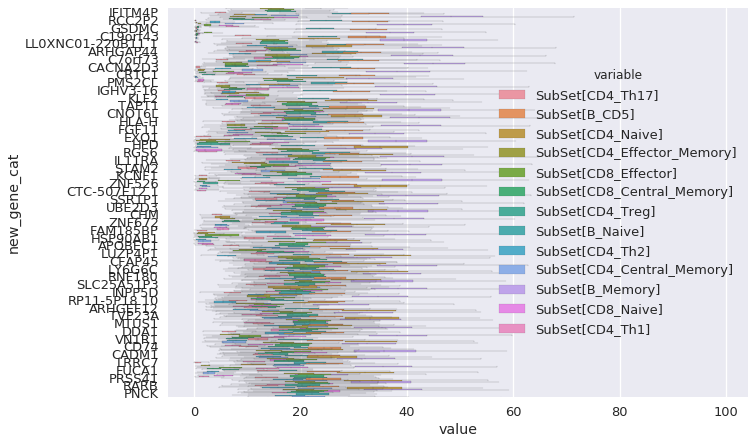

In [16]:
## show theta estimates for first 50 genes, by `sort-by`
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_value_rank_{}'.format(sort_by)] <= 50,:] \
                .sort_values('mean_value_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, width=2, linewidth=0.2)

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


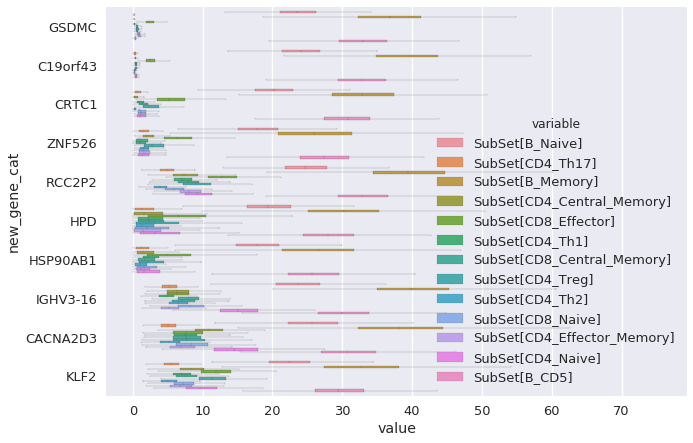

In [18]:
## zoom in on the highest-ranked genes by `sort-by` difference from average 
## across all cell types
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .sort_values('mean_diff_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, linewidth=0.2)

In [17]:
omega = model_fit.extract('Omega')['Omega']

In [20]:
omega.shape

(4000, 13, 13)

In [26]:
print(omega[:, 1, 1].shape, np.mean(omega[:, 0, 0]))
print(omega[:, 0, 1].shape, np.mean(omega[:, 0, 1]))

(4000,) 1.0
(4000,) 0.82567503041


So far so good -- self-correlation is 1, and the non-self correlation matches the print out of Omega posterior means above.

In [27]:
mean_matrix = np.apply_along_axis(np.mean, 0, omega)

In [29]:
print(mean_matrix.shape)
mean_matrix

(13, 13)


array([[ 1.        ,  0.82567503,  0.86804532,  0.24393898,  0.16136129,
         0.14408982,  0.17411624, -0.02281285, -0.10420276,  0.27128552,
         0.08647246,  0.01443822,  0.12025598],
       [ 0.82567503,  1.        ,  0.97496306,  0.63716741,  0.55313892,
         0.55529849,  0.56312387,  0.38352688,  0.32782361,  0.55652543,
         0.51577329,  0.26967884,  0.53050703],
       [ 0.86804532,  0.97496306,  1.        ,  0.59294623,  0.49632265,
         0.51951198,  0.51546156,  0.33608644,  0.28292593,  0.52595075,
         0.45583374,  0.20748639,  0.48690807],
       [ 0.24393898,  0.63716741,  0.59294623,  1.        ,  0.94543509,
         0.90389276,  0.95860014,  0.88572271,  0.81786337,  0.90391052,
         0.9463629 ,  0.71964255,  0.9190305 ],
       [ 0.16136129,  0.55313892,  0.49632265,  0.94543509,  1.        ,
         0.82230667,  0.9584817 ,  0.91907602,  0.85261897,  0.88694234,
         0.9517938 ,  0.83998853,  0.85283181],
       [ 0.14408982,  0.555298

In [44]:
scaled_mat = (mean_matrix - mean_matrix.mean(axis=0)) / mean_matrix.std(axis=0)
scaled_mat2 = (mean_matrix - mean_matrix.mean(axis=0))
scaled_mat

array([[ 2.03486231,  1.0873862 ,  1.29859106, -2.76730471, -2.70357187,
        -2.59173953, -2.71628905, -2.57389542, -2.55875883, -2.52744364,
        -2.70177222, -2.19179276, -2.62683534],
       [ 1.53455998,  1.89784558,  1.74734429, -0.83032211, -1.0125168 ,
        -0.80881246, -1.0172563 , -1.19159822, -1.15386   , -1.00762673,
        -1.03074967, -1.25903212, -0.90764464],
       [ 1.65616019,  1.78144558,  1.85242891, -1.04814882, -1.25775654,
        -0.96397634, -1.22542655, -1.35298237, -1.29986194, -1.17053495,
        -1.26406004, -1.4863105 , -1.09034965],
       [-0.134988  ,  0.21098982,  0.14395006,  0.95693528,  0.68077648,
         0.70262986,  0.71002896,  0.51678478,  0.43969154,  0.84331247,
         0.64528941,  0.38533162,  0.72049485],
       [-0.37198107, -0.17966951, -0.2615967 ,  0.68815695,  0.91629852,
         0.34888718,  0.70951164,  0.63024693,  0.55271266,  0.75290251,
         0.66642878,  0.82512834,  0.44308382],
       [-0.42154916, -0.169629

In [45]:
# confirm each row has 0 mean and unit variance (in scaled mat 1)
scaled_mat.mean(axis=0), scaled_mat.std(axis=0), scaled_mat2.mean(axis=0), scaled_mat2.std(axis=0)

(array([  2.98906199e-17,  -4.14198590e-16,   3.41607085e-17,
          2.90366022e-16,   2.56205313e-17,  -3.50147262e-16,
         -6.10622664e-16,  -5.55111512e-17,  -1.70803542e-17,
          4.56899476e-16,  -1.28102657e-16,   1.77208675e-16,
         -6.31973106e-16]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([  0.00000000e+00,  -8.11316826e-17,   1.28102657e-17,
          5.12410627e-17,   2.56205313e-17,  -7.68615940e-17,
         -1.28102657e-16,  -3.41607085e-17,  -2.56205313e-17,
          6.83214169e-17,  -3.41607085e-17,   7.68615940e-17,
         -1.62263365e-16]),
 array([ 0.34843925,  0.21509402,  0.23825508,  0.20301082,  0.23167645,
         0.23063684,  0.22895829,  0.29395974,  0.30751422,  0.18768044,
         0.25690906,  0.27364001,  0.23863033]))

In [46]:
colnames_filtered = [c.replace('SubSet[', '').replace(']', '') for c in colnames]
colnames_filtered

['B_CD5',
 'B_Memory',
 'B_Naive',
 'CD4_Central_Memory',
 'CD4_Effector_Memory',
 'CD4_Naive',
 'CD4_Th1',
 'CD4_Th17',
 'CD4_Th2',
 'CD4_Treg',
 'CD8_Central_Memory',
 'CD8_Effector',
 'CD8_Naive']

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


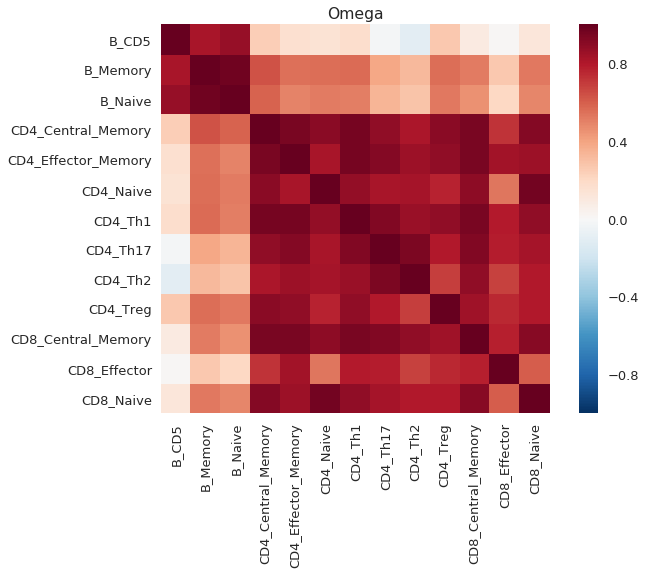

In [47]:
g = sns.heatmap(mean_matrix, square=True,
                xticklabels=colnames_filtered,
                yticklabels=colnames_filtered
               )
plt.title('Omega')
#plt.savefig('plots/lm22.corr.png', dpi=300)

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


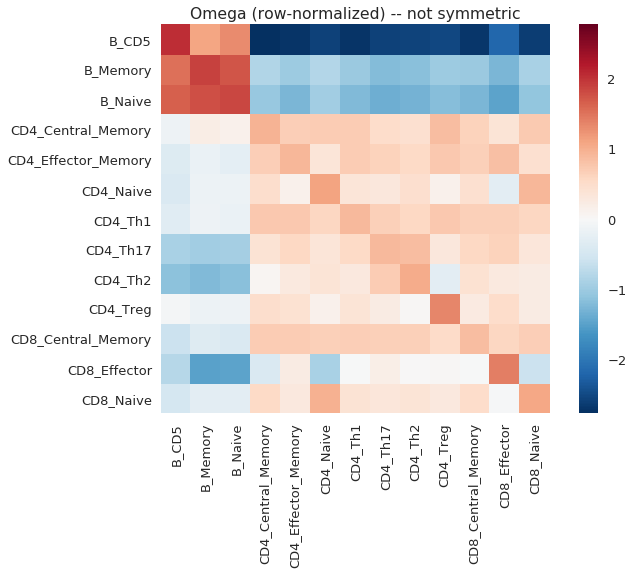

In [48]:
g = sns.heatmap(scaled_mat, square=True,
                xticklabels=colnames_filtered,
                yticklabels=colnames_filtered
               )
plt.title('Omega (row-normalized) -- not symmetric')
#plt.savefig('plots/lm22.corr.png', dpi=300)

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


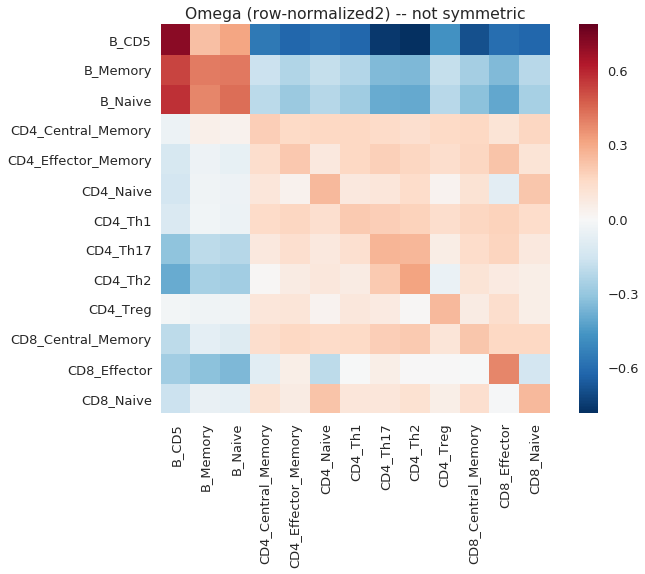

In [49]:
g = sns.heatmap(scaled_mat2, square=True,
                xticklabels=colnames_filtered,
                yticklabels=colnames_filtered
               )
plt.title('Omega (row-normalized2) -- not symmetric')
#plt.savefig('plots/lm22.corr.png', dpi=300)

now dendrogram

see

* https://stats.stackexchange.com/a/165234/297, which suggests row normalize
* http://research.stowers.org/mcm/efg/R/Visualization/cor-cluster/index.htm: basically for distance metric use `1 - abs(corr)` or `1 - corr` 
* https://www.personality-project.org/r/html/cor2dist.html: $d = \sqrt{(2(1-r))}$, which maps (-1,1) to (0,2).
* https://rdrr.io/cran/ape/man/vcv2phylo.html : http://www.mpcm-evolution.org/OPM/Chapter5_OPM/download/vcv2phylo.R
* https://plot.ly/python/dendrogram/
* https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

first have to convert square distance matrix into their desired 1d form

In [78]:
import scipy
pdist = scipy.spatial.distance.squareform(scaled_mat) 
pdist

ValueError: Distance matrix 'X' must be symmetric.

In [79]:
import scipy
pdist = scipy.spatial.distance.squareform(scaled_mat2)
pdist

ValueError: Distance matrix 'X' must be symmetric.

In [80]:
import scipy
pdist = scipy.spatial.distance.squareform(mean_matrix)
pdist

ValueError: Distance matrix 'X' diagonal must be zero.

In [81]:
discorr = 1-mean_matrix # negatives are farther distance
pdist = scipy.spatial.distance.squareform(discorr)
pdist

array([ 0.17432497,  0.13195468,  0.75606102,  0.83863871,  0.85591018,
        0.82588376,  1.02281285,  1.10420276,  0.72871448,  0.91352754,
        0.98556178,  0.87974402,  0.02503694,  0.36283259,  0.44686108,
        0.44470151,  0.43687613,  0.61647312,  0.67217639,  0.44347457,
        0.48422671,  0.73032116,  0.46949297,  0.40705377,  0.50367735,
        0.48048802,  0.48453844,  0.66391356,  0.71707407,  0.47404925,
        0.54416626,  0.79251361,  0.51309193,  0.05456491,  0.09610724,
        0.04139986,  0.11427729,  0.18213663,  0.09608948,  0.0536371 ,
        0.28035745,  0.0809695 ,  0.17769333,  0.0415183 ,  0.08092398,
        0.14738103,  0.11305766,  0.0482062 ,  0.16001147,  0.14716819,
        0.12343499,  0.17354322,  0.17144313,  0.2276793 ,  0.10639916,
        0.4657297 ,  0.03294457,  0.07552537,  0.13875654,  0.11619798,
        0.04969379,  0.20636543,  0.11137875,  0.05788141,  0.19721054,
        0.0747339 ,  0.21245831,  0.17073218,  0.30830545,  0.11

In [82]:
from scipy.cluster.hierarchy import dendrogram, linkage


In [83]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
links = linkage(pdist, 'ward') # row i is which clusters were merged in i-th iteration, their distance, and their sample count
print(links)
from scipy.cluster.hierarchy import cophenet
c, _ = cophenet(links, pdist)
c # want close to 1: means actual pairwise distances well preserved by hierarchical clustering

[[  1.           2.           0.02503694   2.        ]
 [  5.          12.           0.03294457   2.        ]
 [  3.           6.           0.04139986   2.        ]
 [  4.          10.           0.0482062    2.        ]
 [ 15.          16.           0.05481662   4.        ]
 [  7.           8.           0.05788141   2.        ]
 [  9.          17.           0.14897811   5.        ]
 [  0.          13.           0.17792847   3.        ]
 [ 14.          19.           0.22407332   7.        ]
 [ 18.          21.           0.25286111   9.        ]
 [ 11.          22.           0.3746127   10.        ]
 [ 20.          23.           1.4390775   13.        ]]


0.8775072323495372

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


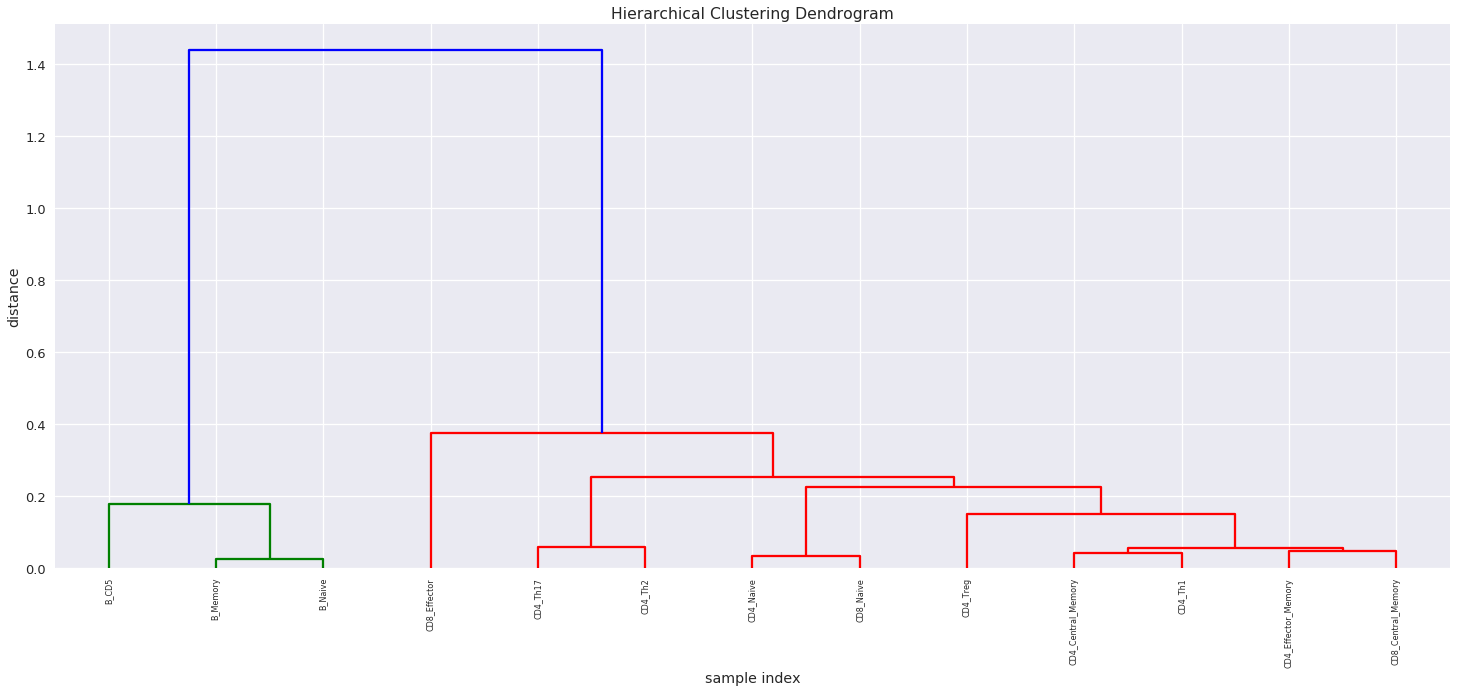

In [84]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    links,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=colnames_filtered
)
plt.show()

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


array([ 0.59046587,  0.5137211 ,  1.22968372,  1.29509745,  1.30836553,
        1.28521108,  1.43025372,  1.4860705 ,  1.20724022,  1.35168601,
        1.40396708,  1.32645695,  0.22377195,  0.85185984,  0.9453688 ,
        0.94308166,  0.93474717,  1.11038112,  1.15946228,  0.94177977,
        0.98410031,  1.20857036,  0.96901287,  0.90227908,  1.00367061,
        0.98029385,  0.98441702,  1.15231381,  1.19755924,  0.9737035 ,
        1.04323177,  1.25897864,  1.01300733,  0.33034803,  0.43842271,
        0.2877494 ,  0.47807382,  0.60355055,  0.4383822 ,  0.32752739,
        0.74880899,  0.40241646,  0.59614315,  0.28816072,  0.40230332,
        0.54291994,  0.47551585,  0.31050346,  0.56570571,  0.54252777,
        0.49686011,  0.58914042,  0.58556492,  0.67480263,  0.46130068,
        0.96512145,  0.2566888 ,  0.38865247,  0.5267951 ,  0.48207464,
        0.31525797,  0.64244132,  0.47197193,  0.34023935,  0.62802953,
        0.38661065,  0.65185629,  0.58434952,  0.78524576,  0.47

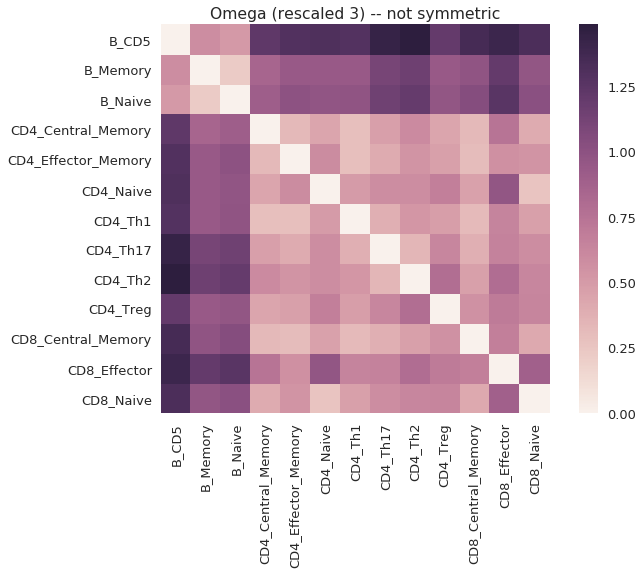

In [88]:
# make into distance matrix as suggested in links above
rescaled = np.sqrt(2*(1-mean_matrix))
#rescaled /= 2 # my own
g = sns.heatmap(rescaled, square=True,
                xticklabels=colnames_filtered,
                yticklabels=colnames_filtered
               )
plt.title('Omega (rescaled 3) -- not symmetric')
#plt.savefig('plots/lm22.corr.png', dpi=300)

pdist = scipy.spatial.distance.squareform(rescaled)
pdist

In [89]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
links = linkage(pdist, 'ward') # row i is which clusters were merged in i-th iteration, their distance, and their sample count
print(links)
from scipy.cluster.hierarchy import cophenet
c, _ = cophenet(links, pdist)
c # want close to 1: means actual pairwise distances well preserved by hierarchical clustering

[[  1.           2.           0.22377195   2.        ]
 [  5.          12.           0.2566888    2.        ]
 [  3.           6.           0.2877494    2.        ]
 [  4.          10.           0.31050346   2.        ]
 [ 15.          16.           0.33137297   4.        ]
 [  7.           8.           0.34023935   2.        ]
 [  9.          17.           0.57016182   5.        ]
 [  0.          13.           0.62584469   3.        ]
 [ 14.          19.           0.74438273   7.        ]
 [ 18.          21.           0.7679217    9.        ]
 [ 11.          22.           0.89935682  10.        ]
 [ 20.          23.           2.24864844  13.        ]]


0.91044079342543205

In [106]:
def savefig(fig, *args, **kwargs):
    """
    Wrap figure.savefig defaulting to tight bounding box.
    From https://github.com/mwaskom/seaborn/blob/dfdd1126626f7ed0fe3737528edecb71346e9eb0/seaborn/axisgrid.py#L1840
    """
    kwargs.setdefault("bbox_inches", "tight")
    fig.savefig(*args, **kwargs)

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


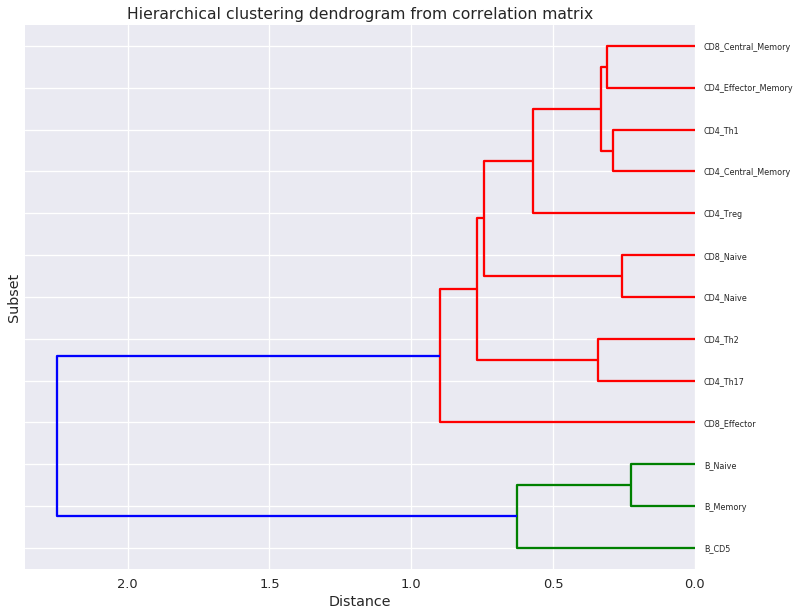

In [109]:
# plt.figure(figsize=(25, 10))
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     links,
#     leaf_rotation=90.,  # rotates the x axis labels
#     leaf_font_size=8.,  # font size for the x axis labels
#     labels=colnames_filtered
# )

f = plt.figure(figsize=(12, 10))
dendrogram(
    links,
    #leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=colnames_filtered,
    orientation='left'
)
plt.xlabel('Distance')
plt.ylabel('Subset')


plt.title('Hierarchical clustering dendrogram from correlation matrix')
savefig(f, 'plots/dendrogram.png', dpi=300)

/home/maxim/miniconda3/envs/immuneinf/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


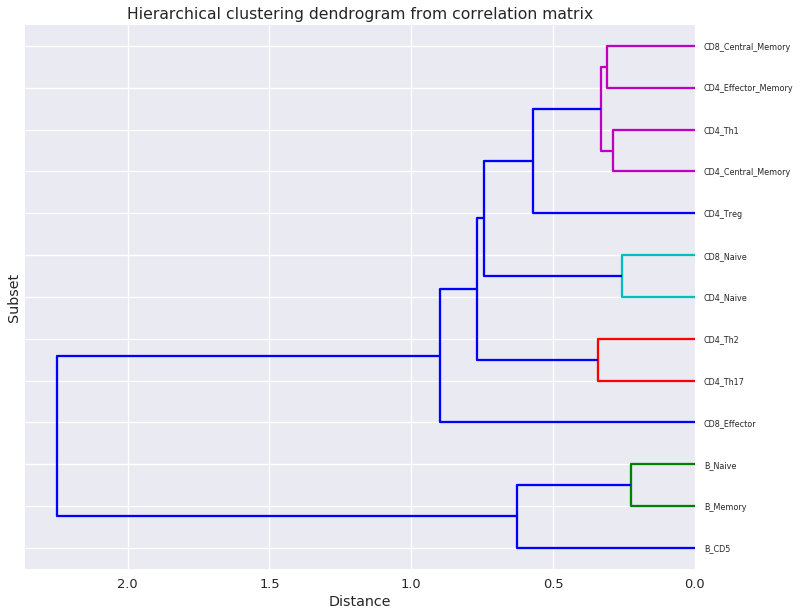

In [107]:
f = plt.figure(figsize=(12, 10))
dendrogram(
    links,
    #leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=colnames_filtered,
    orientation='left',
    color_threshold=0.5
)
plt.xlabel('Distance')
plt.ylabel('Subset')


plt.title('Hierarchical clustering dendrogram from correlation matrix')
savefig(f, 'plots/dendrogram2.png', dpi=300)